# Web Scraping Using BeautifulSoup

## Importing the libraries

In [40]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import requests

# Removing row limits from pandas
pd.set_option('display.max_rows', None)

## Loading the initial page

In [41]:
# Load the page content
url = 'https://www.skinnytaste.com/recipe-index/?_paged=1'
page = requests.get(url)

# Check status
if page.status_code == 200:
  print('Page loaded')
elif page.status_code == 404:
  print('Not found')

print(page.url)
print(page.headers)

# Convert into a BeautifulSoup object
soup = bs(page.content, 'html.parser')

Page loaded
https://www.skinnytaste.com/recipe-index/?_paged=1
{'Date': 'Wed, 25 Sep 2024 16:00:41 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'vary': 'Accept-Encoding', 'Cache-Control': 'no-store, no-cache, must-revalidate, max-age=0', 'pragma': 'no-cache', 'expires': 'Wed, 25 Sep 2024 16:00:41 GMT', 'x-bigscoots-cache': 'no-cache', 'x-bigscoots-cache-control': 'no-store, no-cache, must-revalidate, max-age=0', 'x-bigscoots-cache-plan': 'Standard', 'link': '<https://www.skinnytaste.com/wp-json/>; rel="https://api.w.org/", <https://www.skinnytaste.com/wp-json/wp/v2/pages/21165>; rel="alternate"; title="JSON"; type="application/json", <https://www.skinnytaste.com/?p=21165>; rel=shortlink', 'x-wordlift-includeexclude-stage-0': 'Filter Called with default include', 'x-wordlift-includeexclude-stage-1': 'Condition Matched for https://www.skinnytaste.com/recipe-index/', 'x-wordlift-includeexclude-note': 'To bypass the Include/E

## Scraping the first page and finding the needed information

In [42]:
# Looking for urls and titles
recipes = soup.find_all('h2')

# Looping through the list to extract information
for recipe in recipes[:20]:
  recipe_url = recipe.find('a')['href']
  recipe_soup = bs(requests.get(recipe_url).text, 'html.parser')
# Checking if the recipe has points, to make sure it's a recipe and not a promotion or a collection
  points_tag = recipe_soup.find('span', class_='recipe-meta-value recipe-ww-pp icon')
  if points_tag:
    valid_points = points_tag.text
  else:
    continue

  # Extracting title
  title = recipe_soup.find('h1', class_='entry-title').text

  # Extracting first the figure, then image information
  figure = recipe_soup.find('div', class_='wprm-recipe-image wprm-block-image-normal')
  if figure:
    image = figure.find('img').get('data-lazy-src')
    if not image:
      image = figure.find('img').get('src')
  else:
    image = 'No picture available'

  # Calories consists of label and the value, extracting just the value
  calories = recipe_soup.find('span', class_='recipe-meta-value value-calories').text.split()[1]
  summary = recipe_soup.find('p').text

  # Find all <ul> elements in the recipe keys section
  recipe_keys_section = recipe_soup.find_all('ul', class_='cat-icons post-icons')

  # Initialize an empty list to store the keys
  recipe_keys_list = []

  # Loop through each <ul> element
  for section in recipe_keys_section:
    keys = section.find_all('li')

    #Extract the text from each <li> and add it to the list
    for key in keys:
      a_tag = key.find('a')
      if a_tag:
        recipe_key_text = a_tag['title']
        recipe_keys_list.append(recipe_key_text)
  print(f'{title}, {image}, {calories}, {valid_points}, {summary}, {recipe_keys_list}')

Crustless Pumpkin Pie, https://www.skinnytaste.com/wp-content/uploads/2024/09/Crustless-Pumpkin-Pies-10-260x260.jpg, 124.5, 2, Skip the crust and make this easy gluten-free, dairy-free crustless pumpkin pie this fall for a cozy night when you crave a pumpkin treat or as a healthier alternative for Thanksgiving., ['Dairy Free Recipes', 'Gluten Free', 'High-Fiber Recipes', 'Vegetarian Meals']
Red Curry Salmon, https://www.skinnytaste.com/wp-content/uploads/2024/09/One-Pan-Red-Curry-Salmon-6-260x260.jpg, 349, 6, Thai-inspired Red Curry Salmon is simmered in an incredibly tasty coconut red curry sauce with bell peppers, garlic and onions., ['Dairy Free Recipes', 'Gluten Free', 'High Protein Recipes']
Apple Butter, https://www.skinnytaste.com/wp-content/uploads/2024/09/Apple-Butter-6-260x260.jpg, 34, 1, This easy apple butter recipe simmers on the stove, made with apples, cinnamon, nutmeg, and allspice, it smells and tastes like fall!, ['Dairy Free Recipes', 'Gluten Free', 'Kid Friendly', '

## Getting information from 50 pages

In [14]:
recipe_names = []
recipe_images = []
recipe_calories = []
recipe_points = []
recipe_summaries = []
recipe_keys = []

for i in range(1, 51):
  url = f'https://www.skinnytaste.com/recipe-index/?_paged={i}'
  soup = bs(requests.get(url).text, 'html.parser')
  all_recipes = soup.find_all('h2')

  # Looping through the list to extract information
  recipes_to_scrape = all_recipes[:20]

  # Looping through the selected list of elements
  for recipe in recipes_to_scrape:
    a_tag = recipe.find('a')  # Find the <a> tag

  # Check if <a> tag exists
    if a_tag and 'href' in a_tag.attrs:
      recipe_url = a_tag['href']
    else:
      # Skip recipe
      continue

  # Converting the recipe to a BeautifulSoup object
    recipe_soup = bs(requests.get(recipe_url).text, 'html.parser')

    # Checking if the recipe has points, to make sure it's a recipe and not a promotion or a collection
    points_tag = recipe_soup.find('span', class_='recipe-meta-value recipe-ww-pp icon')
    if points_tag:
      valid_points = points_tag.text
    else:
      continue

    title = recipe_soup.find('h1', class_='entry-title').text

    # Extracting first the image container, then image information, either data-lazy-src or src
    figure = recipe_soup.find('div', class_='wprm-recipe-image wprm-block-image-normal')
    if figure:
      image = figure.find('img').get('data-lazy-src')
      if not image:
        image = figure.find('img').get('src')
    else:
      image = 'No picture available'

    # Calories consists of label and the value, extracting just the value
    calories = recipe_soup.find('span', class_='recipe-meta-value value-calories').text.split()[1]
    summary = recipe_soup.find('p').text

    # Find all <ul> elements in the recipe keys section
    recipe_keys_section = recipe_soup.find_all('ul', class_='cat-icons post-icons')

    # Initialize an empty list to store the keys
    current_recipe_keys = []

    # Loop through each <ul> element
    for section in recipe_keys_section:
      keys = section.find_all('li')

      #Extract the <a> from each <li>, extract title from a_tag and add it to the list
      for key in keys:
        a_tag = key.find('a')
        if a_tag:
          recipe_key_text = a_tag['title']
          current_recipe_keys.append(recipe_key_text)
    recipe_names.append(title)
    recipe_images.append(image)
    recipe_calories.append(float(calories))
    recipe_points.append(int(valid_points))
    recipe_summaries.append(summary)
    recipe_keys.append(current_recipe_keys)
print(len(recipe_names))

938


## Putting the information in a DataFrame

In [51]:
import pandas as pd

recipes_df = pd.DataFrame({'Title': recipe_names, 'Image': recipe_images,
                           'Calories': recipe_calories, 'Points': recipe_points,
                           'Summary': recipe_summaries, 'Keys': recipe_keys
                           })
# Setting the index to start from 1
recipes_df.index = recipes_df.index + 1

recipes_df.head()

,Title,Image,Calories,Points,Summary,Keys
1,Crustless Pumpkin Pie,https://www.skinnytaste.com/wp-content/uploads...,124.5,2,"Skip the crust and make this easy gluten-free,...","[Dairy Free Recipes, Gluten Free, High-Fiber R..."
2,Red Curry Salmon,https://www.skinnytaste.com/wp-content/uploads...,349.0,6,Thai-inspired Red Curry Salmon is simmered in ...,"[Dairy Free Recipes, Gluten Free, High Protein..."
3,Apple Butter,https://www.skinnytaste.com/wp-content/uploads...,34.0,1,This easy apple butter recipe simmers on the s...,"[Dairy Free Recipes, Gluten Free, Kid Friendly..."
4,Roasted Delicata Squash,https://www.skinnytaste.com/wp-content/uploads...,177.0,4,"Roasted Delicata Squash with toasted almonds, ...","[Dairy Free Recipes, Gluten Free, Vegetarian M..."
5,Apple Bread,https://www.skinnytaste.com/wp-content/uploads...,124.0,4,Moist cinnamon apple bread recipe made with ap...,[Vegetarian Meals]


## EDA and Visualization

### Distribution of Calories

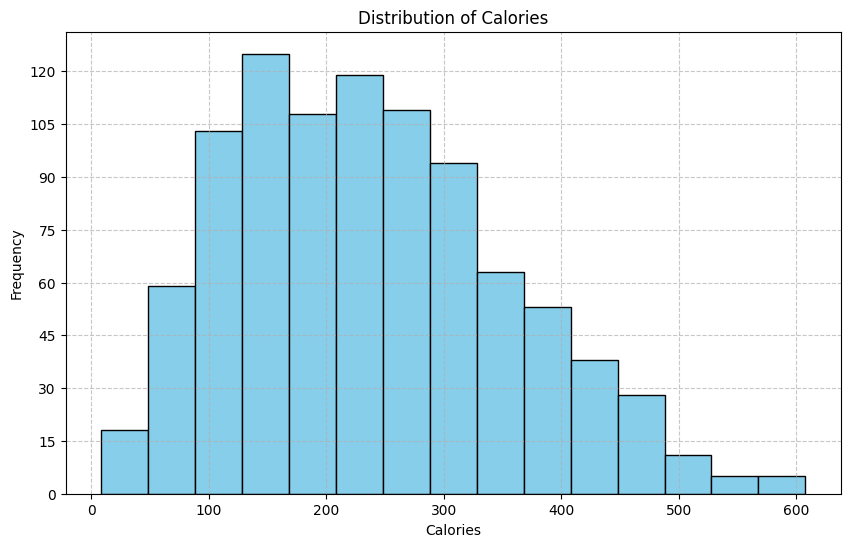

In [44]:
# Dropping any missing values
recipes_df = recipes_df.dropna(subset=['Calories'])

# Plotting the histogram
plt.figure(figsize=(10,6))
recipes_df['Calories'].hist(bins=15, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.title('Distribution of Calories')

# Changing the y-axis to show whole numbers
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Gridlines for readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Distribution of Recipe Keys

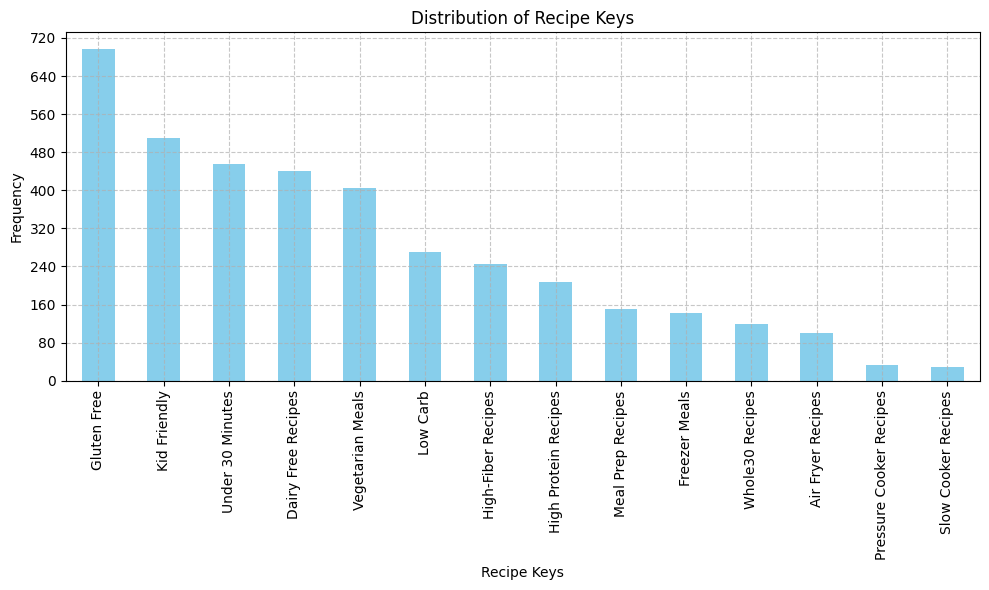

In [45]:
# Exploding the keys column to get one recipe key per row
exploded_keys = recipes_df.explode('Keys')

# Counting the occurrences
key_counts = exploded_keys['Keys'].value_counts()

# Plotting the distribution as a bar chart
plt.figure(figsize=(10, 6))
key_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Distribution of Recipe Keys')
plt.xlabel('Recipe Keys')
plt.ylabel('Frequency')

# Changing the y-axis to show whole numbers
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Gridlines for readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()

### Points distribution

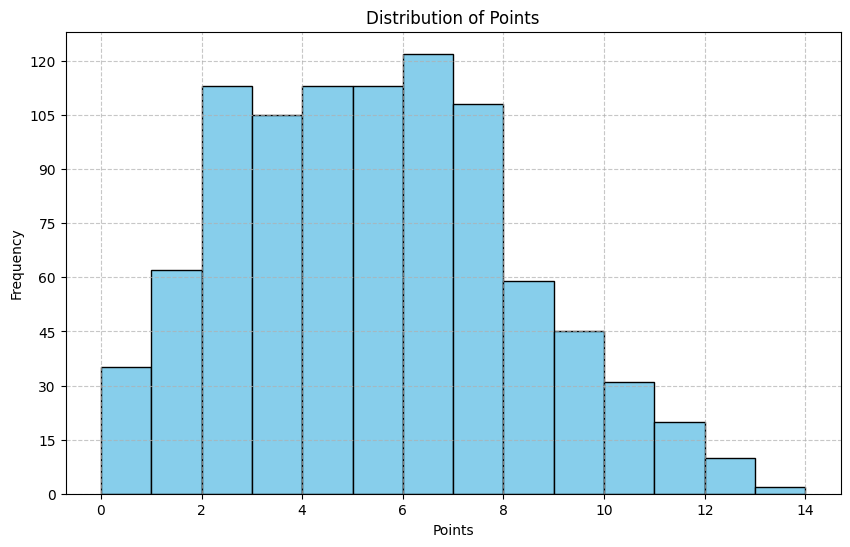

In [46]:
# Converting points to integer type
recipes_df['Points'] = recipes_df['Points'].astype(int)

# Defining bins to align with integer points
max_points = recipes_df['Points'].max()
min_points = recipes_df['Points'].min()
bins = range(min_points, max_points + 2)

# Plotting the histogram
plt.figure(figsize=(10,6))
recipes_df['Points'].hist(bins=bins, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.title('Distribution of Points')

# Changing the y-axis to show whole numbers
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Gridlines for readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## User Interaction

In [50]:
# Get a calorie range from a user
print('Please input your calorie range')
min_calories = int(input('Enter the minimum number of calories: '))
max_calories = int(input('Enter the minimum number of calories: '))

# Filter the DataFrame based on the user input
filtered_recipes = recipes_df[(recipes_df['Calories'] >= min_calories) & (recipes_df['Calories'] <= max_calories)]

print(f'Recipes with calories between {min_calories} and {max_calories}:')
filtered_recipes.head()

Please input your calorie range
Enter the minimum number of calories: 400
Enter the minimum number of calories: 500
Recipes with calories between 400 and 500:


,Title,Image,Calories,Points,Summary,Keys
10,Homemade Hamburger Helper,https://www.skinnytaste.com/wp-content/uploads...,453.0,12,"This one-skillet, creamy Homemade Hamburger He...","[Dairy Free Recipes, Gluten Free, High Protein..."
19,Shrimp and Rice (Arroz Con Camarones),https://www.skinnytaste.com/wp-content/uploads...,433.0,9,Costa Rican Inspired Shrimp and Rice (Arroz Co...,"[Dairy Free Recipes, Gluten Free, High Protein..."
45,Grilled Skirt Steak and Elote Tacos,https://www.skinnytaste.com/wp-content/uploads...,418.0,10,Grilled skirt steak tacos topped with Mexican ...,"[Gluten Free, High Protein Recipes, Kid Friendly]"
56,Nicoise Salad,https://www.skinnytaste.com/wp-content/uploads...,494.0,5,I used salmon in place of tuna in this variati...,"[Dairy Free Recipes, Gluten Free, High Protein..."
59,Coconut Chicken Rice Bowl,https://www.skinnytaste.com/wp-content/uploads...,429.0,8,This quick and easy high-protein Coconut Chick...,"[Dairy Free Recipes, Gluten Free, High Protein..."


In [49]:
# Get a point range from a user
print('Please input your point range')
min_points = int(input('Enter the minimum number of points: '))
max_points = int(input('Enter the minimum number of points: '))

# Filter the DataFrame based on the user input
filtered_recipes = recipes_df[(recipes_df['Points'] >= min_points) & (recipes_df['Points'] <= max_points)]
filtered_recipes
print(f'Recipes with calories between {min_points} and {max_points}:')
filtered_recipes.head()

Please input your point range
Enter the minimum number of points: 3
Enter the minimum number of points: 5
Recipes with calories between 3 and 5:


,Title,Image,Calories,Points,Summary,Keys
4,Roasted Delicata Squash,https://www.skinnytaste.com/wp-content/uploads...,177.0,4,"Roasted Delicata Squash with toasted almonds, ...","[Dairy Free Recipes, Gluten Free, Vegetarian M..."
5,Apple Bread,https://www.skinnytaste.com/wp-content/uploads...,124.0,4,Moist cinnamon apple bread recipe made with ap...,[Vegetarian Meals]
6,Autumn Salad with Pears and Gorgonzola,https://www.skinnytaste.com/wp-content/uploads...,175.0,5,I love a good salad with lots of texture and f...,"[Gluten Free, Low Carb, Under 30 Minutes, Vege..."
12,Asian Grilled Chicken,https://www.skinnytaste.com/wp-content/uploads...,288.5,4,This Asian Grilled Chicken recipe is the perfe...,"[Dairy Free Recipes, Gluten Free, Kid Friendly..."
15,Pretzel Crusted Chicken Tenders,https://www.skinnytaste.com/wp-content/uploads...,267.0,4,"Craving something crispy, kid-friendly, and ab...","[Air Fryer Recipes, Dairy Free Recipes, Freeze..."


In [48]:
# Sorting the DataFrame by calories
sorted_recipes = recipes_df.sort_values(by=['Calories'], ascending=False)
top_10_recipes = sorted_recipes.head(10)


top_10_df = top_10_recipes[['Title', 'Calories', 'Image', 'Summary']].reset_index(drop=True)
top_10_df.index = top_10_df.index + 1

# Display the DataFrame
top_10_df

,Title,Calories,Image,Summary
1,Sheet Pan Thanksgiving Dinner for Four,608.0,https://www.skinnytaste.com/wp-content/uploads...,This easy Sheet Pan Thanksgiving dinner for fo...
2,Beef Stew with Pumpkin,600.0,https://www.skinnytaste.com/wp-content/uploads...,This hearty beef stew recipe cooks low and slo...
3,Baked Chicken Thighs with Brussels and Sweet P...,587.0,https://www.skinnytaste.com/wp-content/uploads...,Baked Chicken Thighs with Brussels Sprouts and...
4,Roasted Sweet Potato Black Bean Bowls,585.0,https://www.skinnytaste.com/wp-content/uploads...,These Roasted Sweet Potato Black Bean Bowls wi...
5,White Bean Scampi with Linguine,571.0,https://www.skinnytaste.com/wp-content/uploads...,This white bean scampi served over whole-wheat...
6,Air Fryer Chicken Milanese with Mediterranean ...,562.0,https://www.skinnytaste.com/wp-content/uploads...,This crispy Air Fryer Breaded Chicken Breast i...
7,Ahi Tuna Poke Stacks,561.0,https://www.skinnytaste.com/wp-content/uploads...,Ahi Tuna Poke Rice Stacks with layers of chunk...
8,Ratatouille Baked Chicken,543.0,https://www.skinnytaste.com/wp-content/uploads...,Ratatouille Baked Chicken takes a classic Fren...
9,5-Minute Microwave Salmon Rice Bowl with Bok Choy,533.0,https://www.skinnytaste.com/wp-content/uploads...,"If you don’t have time to cook, you’ll love th..."
10,Burma Superstar Chicken Dal Curry,529.0,https://www.skinnytaste.com/wp-content/uploads...,Chicken Dal Curry is a comforting Burmese stew...
